In [9]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

Importation of Dataset 2

In [10]:
# CHOOSE DATASET

# Binary classification dataset
diabetes =fetch_openml("diabetes", version = 1, as_frame=True)

X = diabetes.data.values
y = diabetes.target.values

y = np.where(y == "tested_positive", 1, 0)

print("Shape:", X.shape)

print(diabetes.data.head(), "\n \n")# first rows of features
print(diabetes.target.head()) # first rows of target

Shape: (768, 8)
   preg  plas  pres  skin  insu  mass   pedi  age
0     6   148    72    35     0  33.6  0.627   50
1     1    85    66    29     0  26.6  0.351   31
2     8   183    64     0     0  23.3  0.672   32
3     1    89    66    23    94  28.1  0.167   21
4     0   137    40    35   168  43.1  2.288   33 
 

0    tested_positive
1    tested_negative
2    tested_positive
3    tested_negative
4    tested_positive
Name: class, dtype: category
Categories (2, object): ['tested_negative', 'tested_positive']


In [11]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [12]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

A fixed seed was added to this code to ensure the reproducibility of the analysis. This allowed for manual tuning of the hyperparameters to achieve better model training.

In [13]:
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Para GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Tornar CUDA determinístico
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

For this model, the number of neurons per layer was increased from 64 to 100. This change was made after observing that a higher number of neurons per layer could lead to improved model performance.

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()

        a = 100

        self.fc1 = nn.Linear(input_size, a)
        self.fc2 = nn.Linear(a, a)
        self.fc3 = nn.Linear(a, a)
        self.fc4 = nn.Linear(a, a)
        self.out = nn.Linear(a, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [15]:
num_epochs=150
lr=0.0001
dropout=0.1
batch_size=128

This model was trained on the GPU and then transferred to the CPU for use with NumPy. Given the low number of parameters (i.e., the model's low complexity), the time required on the CPU was similar to that on the GPU.

In [16]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"  # force to use CPU
print(device)

cuda


In [17]:
Xtr = torch.tensor(Xtr, dtype=torch.float32).to(device)
ytr = torch.tensor(ytr, dtype=torch.float32).to(device)
Xte = torch.tensor(Xte, dtype=torch.float32).to(device)
yte = torch.tensor(yte, dtype=torch.float32).to("cpu")

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

The model was implemented as a fully connected neural network (MLP) with four hidden layers of 64 neurons each, using ReLU activation functions. The network takes the input features of the dataset and outputs a single value for regression (Diabetes Progression).

In [19]:
# Training loop
import time
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch [1/150], Loss: 0.3047
Epoch [2/150], Loss: 0.2965
Epoch [3/150], Loss: 0.2853
Epoch [4/150], Loss: 0.2748
Epoch [5/150], Loss: 0.2666
Epoch [6/150], Loss: 0.2612
Epoch [7/150], Loss: 0.2516
Epoch [8/150], Loss: 0.2430
Epoch [9/150], Loss: 0.2342
Epoch [10/150], Loss: 0.2262
Epoch [11/150], Loss: 0.2204
Epoch [12/150], Loss: 0.2118
Epoch [13/150], Loss: 0.2021
Epoch [14/150], Loss: 0.2008
Epoch [15/150], Loss: 0.1928
Epoch [16/150], Loss: 0.1910
Epoch [17/150], Loss: 0.1854
Epoch [18/150], Loss: 0.1833
Epoch [19/150], Loss: 0.1756
Epoch [20/150], Loss: 0.1753
Epoch [21/150], Loss: 0.1742
Epoch [22/150], Loss: 0.1699
Epoch [23/150], Loss: 0.1679
Epoch [24/150], Loss: 0.1621
Epoch [25/150], Loss: 0.1665
Epoch [26/150], Loss: 0.1668
Epoch [27/150], Loss: 0.1589
Epoch [28/150], Loss: 0.1595
Epoch [29/150], Loss: 0.1589
Epoch [30/150], Loss: 0.1579
Epoch [31/150], Loss: 0.1586
Epoch [32/150], Loss: 0.1594
Epoch [33/150], Loss: 0.1581
Epoch [34/150], Loss: 0.1524
Epoch [35/150], Loss: 0

In [20]:

thr = 0.6 #threshold to tune

y_pred=model(Xte).cpu()
y_true = yte.detach().numpy()
y_pred_bin = (y_pred.detach().numpy() > thr).astype(int)  # binary predictions

# Accuracy
acc = accuracy_score(y_true, y_pred_bin)
print(f'ACC:{accuracy_score(y_true,y_pred_bin)}') #classification

cm = confusion_matrix(y_true, y_pred_bin)
print("Confusion Matrix:")
print(cm)

#print(f'ACC:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7922077922077922
Confusion Matrix:
[[90  9]
 [23 32]]


After manually tuning the hyperparameters, the best configuration obtained was: num_epochs = 150, lr = 0.0001, dropout = 0.1, and batch_size = 128. Dropout with a probability of 0.1 was applied after each layer to mitigate overfitting. To validate the model, both accuracy and the confusion matrix were computed. An accuracy of 79.22% was achieved, which is comparable to other models. It was observed that the model performs better when predicting negative cases compared to positive cases. This behavior is likely due to the dataset being unbalanced, highlighting the importance of data quality for achieving reliable model performance. One possible approach to address this issue is to oversample the positive class so that both classes have similar representation during training.

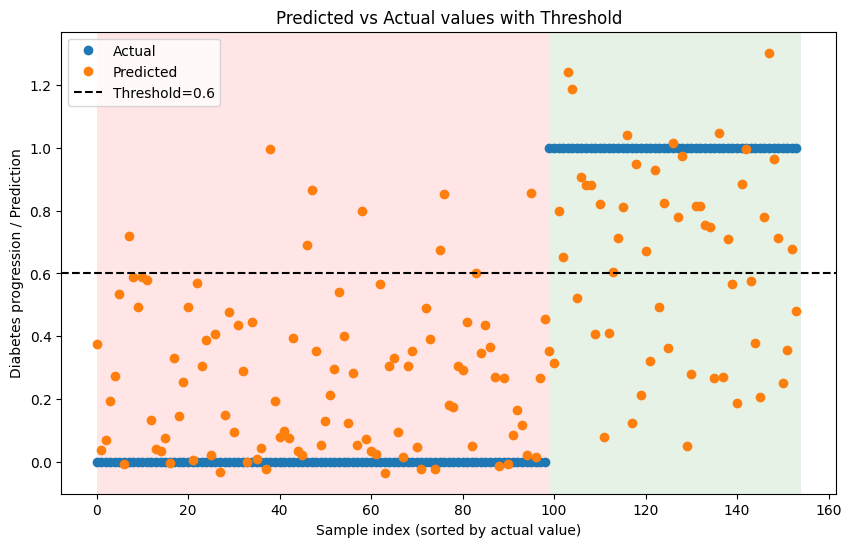

In [21]:
# Convert y_pred to numpy and flatten
y_pred_np = y_pred.detach().numpy().flatten()
y_pred_bin_np = y_pred_bin
yte_np = yte.detach().numpy()

# Get indices that sort yte
sort_idx = np.argsort(yte_np)

# Sort yte and y_pred
yte_sorted = yte_np[sort_idx]
y_pred_sorted = y_pred_np[sort_idx]

# Determine the index where actual target switches from 0 to 1
frontier_idx = np.argmax(yte_sorted == 1)  # first occurrence of 1

# Plot
plt.figure(figsize=(10,6))

# Shade negative region (yte = 0)
plt.axvspan(0, frontier_idx, facecolor='red', alpha=0.1)

# Shade positive region (yte = 1)
plt.axvspan(frontier_idx, len(yte_sorted), facecolor='green', alpha=0.1)

# Actual and predicted points
plt.plot(range(len(yte_sorted)), yte_sorted, label="Actual", marker="o", linestyle='')
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted", marker="o", linestyle='')

# Threshold line
plt.axhline(y=thr, color='k', linestyle='--', label=f'Threshold={thr}')

plt.xlabel("Sample index (sorted by actual value)")
plt.ylabel("Diabetes progression / Prediction")
plt.title("Predicted vs Actual values with Threshold")
plt.legend()
plt.show()